# Cap13 - Sistemas de Controle Digital

## PARTE 2 — PID Discreto, LGR Discreto, ZOH, Monte-Carlo

In [3]:
!pip install control --quiet

import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

plt.rcParams['figure.figsize'] = (8,5)

Gs = ctrl.tf([1], [1, 2, 0])
T = 0.1
Gz = ctrl.sample_system(Gs, T)

print("Tudo carregado!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 14.6 MB/s eta 0:00:00
Tudo carregado!


## 1. Controlador PID discreto

Usamos a forma incremental:

\[
u[k] = u[k-1] + K_p(e[k] - e[k-1]) + K_i T e[k] + \frac{K_d}{T}(e[k] - 2e[k-1] + e[k-2])
\]

Vamos gerar a função de transferência equivalente.


In [4]:
# Exemplo de PID discreto simples
Kp = 2
Ki = 1
Kd = 0.1

# conversão do PID contínuo para discreto (exemplo usando Tustin)
PIDz = ctrl.tf([Kd, Kp, Ki], [1, -1], T)
PIDz


TransferFunction(
array([0.1, 2. , 1. ]),
array([ 1, -1]),
dt=0.1,
outputs=1, inputs=1)

## 2. Malha fechada com PID digital

Aqui simulamos a resposta ao degrau usando G(z) e o PID discretizado.


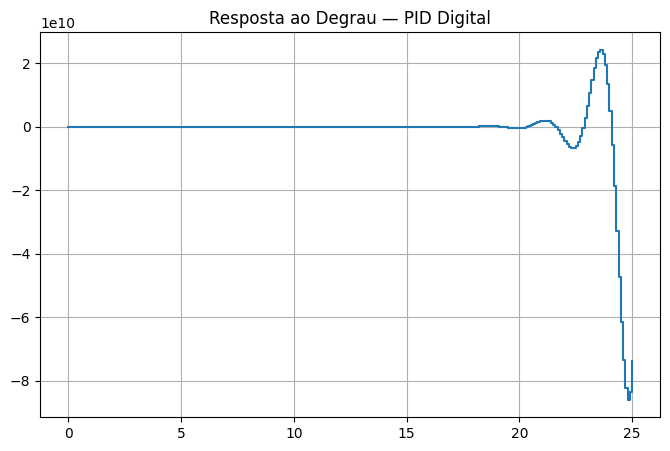

In [5]:
CL = ctrl.feedback(PIDz * Gz, 1)

t,y = ctrl.step_response(CL)

plt.step(t,y,where="post")
plt.title("Resposta ao Degrau — PID Digital")
plt.grid()
plt.show()


## 3. LGR discreto (mapa de polos para vários ganhos)

Para sistemas discretos, analisamos o deslocamento dos polos no plano-z.


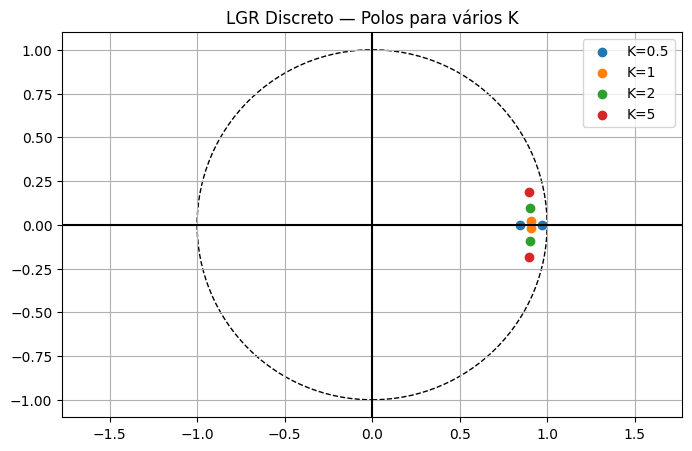

In [7]:
def plot_lgr_discreto(G, K_vals):
    plt.figure()

    circle = plt.Circle((0,0),1, fill=False, linestyle='--')
    plt.gca().add_patch(circle)

    for K in K_vals:
        CL = ctrl.feedback(K*G,1)
        p = ctrl.poles(CL)    # ← CORREÇÃO AQUI
        plt.scatter(np.real(p), np.imag(p), label=f"K={K}")

    plt.axhline(0,color="black")
    plt.axvline(0,color="black")
    plt.title("LGR Discreto — Polos para vários K")
    plt.grid()
    plt.legend()
    plt.axis("equal")
    plt.show()

plot_lgr_discreto(Gz, [0.5, 1, 2, 5])


## 4. Comparação de Controladores Digitais
Simulamos vários controladores digitais variando Kp, Ki, Kd.


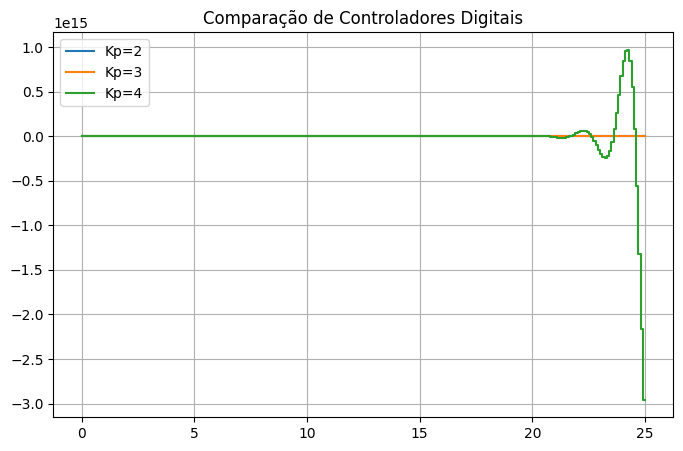

In [8]:
Ks = [(2,1,0.1), (3,1,0.2), (4,2,0.3)]

plt.figure()

for Kp,Ki,Kd in Ks:
    PIDz = ctrl.tf([Kd, Kp, Ki], [1, -1], T)
    CL = ctrl.feedback(PIDz * Gz, 1)
    t,y = ctrl.step_response(CL)
    plt.step(t,y,label=f"Kp={Kp}")

plt.legend()
plt.title("Comparação de Controladores Digitais")
plt.grid()
plt.show()


## 5. Monte-Carlo Digital
Simulamos incertezas no período de amostragem **T**.


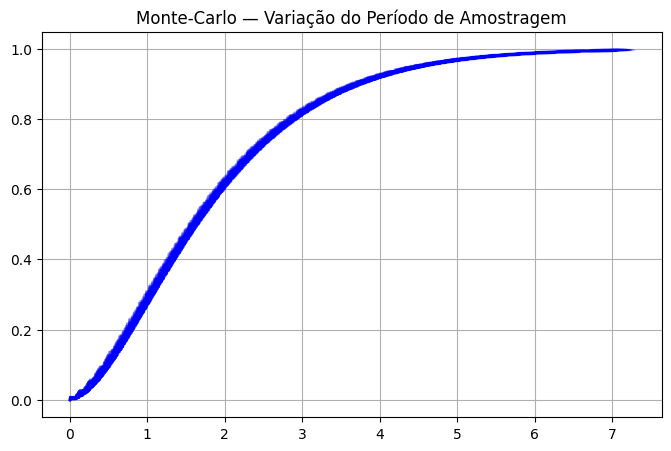

In [9]:
N = 80
plt.figure()

for _ in range(N):
    T_var = 0.1 + np.random.uniform(-0.03, 0.03)
    Gz_var = ctrl.sample_system(Gs, T_var)
    CL = ctrl.feedback(Gz_var, 1)
    t,y = ctrl.step_response(CL)
    plt.step(t,y,alpha=0.2,color="blue")

plt.title("Monte-Carlo — Variação do Período de Amostragem")
plt.grid()
plt.show()


## 6. Resposta ao Impulso Digital
Como o sistema responde ao impulso em tempo discreto.


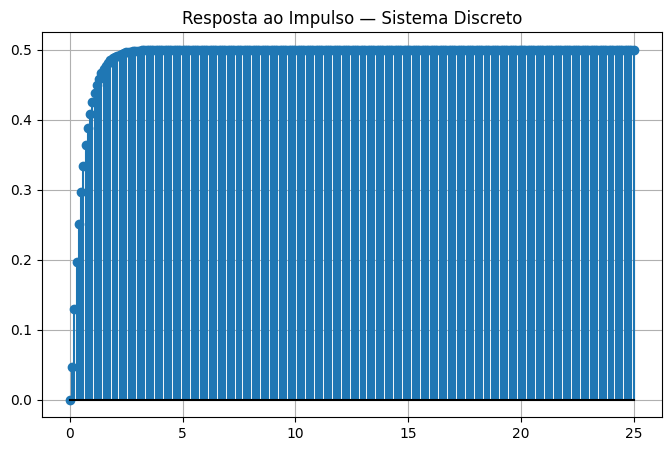

In [10]:
t_imp, y_imp = ctrl.impulse_response(Gz)

plt.stem(t_imp, y_imp, basefmt="k")
plt.title("Resposta ao Impulso — Sistema Discreto")
plt.grid()
plt.show()


## 7. Análise de Estabilidade com Ganho Digital
Estabilidade depende da posição dos polos dentro do círculo unitário.


In [12]:
for K in [0.5, 1, 2, 4]:
    CL = ctrl.feedback(K * Gz, 1)
    p = ctrl.poles(CL)  # ← CORREÇÃO AQUI
    print(f"K={K}, polos:", p)


K=0.5, polos: [0.9706165+0.j 0.8457729+0.j]
K=1, polos: [0.90702403+0.02046782j 0.90702403-0.02046782j]
K=2, polos: [0.90468269+0.09508699j 0.90468269-0.09508699j]
K=4, polos: [0.9+0.1620304j 0.9-0.1620304j]
